# Caida de P$P (Guatemala)

## Conexión con AWS300

In [2]:
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings('ignore')
conn = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};SERVER=AWNTS300;DATABASE=DATALAB;UID=usrdm;PWD=dm$2Admin4')

In [3]:
 #Falta afinar para que sea por país y por campaña
#df = pd.read_sql("select * from [dbo].[CR_INPUT1_PDP]" , conn)
df = pd.read_sql("select * from [dbo].[CR_INPUT1_PDP]" , conn)

#df = pd.read_excel('output.xlsx')
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [4]:
df.head()

,Pkebelista,v201711,v201712,v201713,v201715,Target,Pedidos_ult_18camp,DecilAñoAnterior,PMNPAñoAnterior,DecilCampAnterior,...,ppu201713,Q201711,Q201712,Q201713,FlagIpUnicoZona,pd201711,pd201712,pd201713,CodComportamientoRolling,FechaNacimiento
0,720,6979.771274,4200.445514,6724.908075,8758.605493,0,18,1.0,7152.190837,1,...,8.151404,24,17,25,1,0,0,0,4,1969-02-21
1,89964,2154.041014,2141.305731,2091.087431,2224.961983,0,18,9.0,2047.940153,7,...,12.673257,7,7,5,0,0,0,0,6,1978-12-01
2,90836,1889.314461,3063.642365,2054.850645,4617.455549,0,18,8.0,2190.827464,7,...,8.895457,8,8,7,1,0,0,0,6,1990-11-12
3,263422,2375.302251,2115.988981,2185.302904,5885.626802,0,18,6.0,2650.747593,6,...,16.555325,7,7,4,1,0,0,0,6,1992-05-28
4,267409,1843.579517,1349.515027,1269.000250,2603.406096,0,9,NaN,NaN,10,...,8.751726,5,5,5,1,1,0,0,6,1993-06-01


In [5]:
print('La base de datos cuenta con ' + str(df.shape[0]) + ' filas y ' 
      + str(df.shape[1]) +' columnas.')


La base de datos cuenta con 15605 filas y 26 columnas.


## Preparamos el dataset

In [6]:
#Eliminamos las filas que contengan valores NULL en campos donde no deberían tener.

df = df.dropna(axis=0, how='all', subset=['FechaNacimiento'])

In [7]:
def PromVariacion (num1, num2, num3):
    var1 = ((num2/num1)-1)
    var2 = ((num3/num2)-1)
    PromVar = (var1+var2)/2
    return PromVar*100


In [8]:
df['VarVentas3Camp'] = PromVariacion(df.v201711,df.v201712,df.v201713)
df['VarMCT3Camp'] =PromVariacion(df.mct201711,df.mct201712,df.mct201713)
df['VarPPU3Camp'] =PromVariacion(df.ppu201711,df.ppu201712,df.ppu201713)
df['VarPPU3Camp'] =PromVariacion(df.Q201711,df.Q201712,df.Q201713)
df['PD3Camp'] = df.pd201711 + df.pd201712 +df.pd201713


In [9]:
df1 = df.drop(['v201711', 'v201712','v201713','v201715','mct201711','mct201712','mct201713','ppu201711','ppu201712','ppu201713',
               'Q201711', 'Q201712', 'Q201713', 'pd201711', 'pd201712', 'pd201713'], axis=1)


In [10]:
pd.DataFrame(df1.dtypes, columns = ['Tipo de dato'])

,Tipo de dato
Pkebelista,int64
Target,int64
Pedidos_ult_18camp,int64
DecilAñoAnterior,float64
PMNPAñoAnterior,float64
DecilCampAnterior,int64
PMNPCampAnterior,float64
FlagIpUnicoZona,int64
CodComportamientoRolling,int64
FechaNacimiento,datetime64[ns]


In [11]:
df1['Target'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)


0    9204
1    6401
Name: Target, dtype: int64

In [12]:
import datetime as DT
import numpy as np
import io

now = pd.Timestamp(DT.datetime.now())
df1['FechaNacimiento'] = df1['FechaNacimiento'].where(df1['FechaNacimiento'] < now, df1['FechaNacimiento'] -  np.timedelta64(100, 'Y'))   # 2
df1['Edad'] = (now - df1['FechaNacimiento']).astype('<m8[Y]')    # 3

df2 = df1.drop(['FechaNacimiento'], axis=1)

In [13]:
pd.DataFrame(df2.dtypes, columns = ['Tipo de dato'])

,Tipo de dato
Pkebelista,int64
Target,int64
Pedidos_ult_18camp,int64
DecilAñoAnterior,float64
PMNPAñoAnterior,float64
DecilCampAnterior,int64
PMNPCampAnterior,float64
FlagIpUnicoZona,int64
CodComportamientoRolling,int64
VarVentas3Camp,float64


In [14]:
df2.describe()

,Pkebelista,Target,Pedidos_ult_18camp,DecilAñoAnterior,PMNPAñoAnterior,DecilCampAnterior,PMNPCampAnterior,FlagIpUnicoZona,CodComportamientoRolling,VarVentas3Camp,VarMCT3Camp,VarPPU3Camp,PD3Camp,Edad
count,15605.000000,15605.000000,15605.000000,13389.000000,13389.000000,15605.000000,15605.000000,15605.000000,15605.000000,15605.000000,15605.000000,15605.000000,15605.000000,15605.000000
mean,195126.126370,0.410189,15.488561,5.499664,3266.200045,5.499199,3009.730870,0.372445,5.717655,12.554007,11.016673,16.658453,0.322845,39.961679
std,92750.457536,0.491884,3.320055,2.872233,2361.674620,2.872373,2349.897689,0.483471,0.709639,39.349584,39.523005,49.061038,0.724985,12.930352
min,39.000000,0.000000,3.000000,1.000000,545.821340,1.000000,116.138803,0.000000,2.000000,-74.927721,-74.166667,-77.976190,0.000000,10.000000
25%,117739.000000,0.000000,14.000000,3.000000,2263.271511,3.000000,1904.966350,0.000000,5.000000,-7.772329,-12.500000,-10.000000,0.000000,29.000000
50%,216946.000000,0.000000,17.000000,5.000000,2790.398827,5.000000,2404.716542,0.000000,6.000000,6.065071,4.166667,7.777778,0.000000,38.000000
75%,278756.000000,1.000000,18.000000,8.000000,3632.813576,8.000000,3454.091922,1.000000,6.000000,24.934718,25.000000,30.000000,0.000000,49.000000
max,312147.000000,1.000000,18.000000,10.000000,96510.051673,10.000000,76045.373449,1.000000,7.000000,1826.310517,541.666667,988.095238,7.000000,100.000000


# Exploración y visualización

### 1 variable

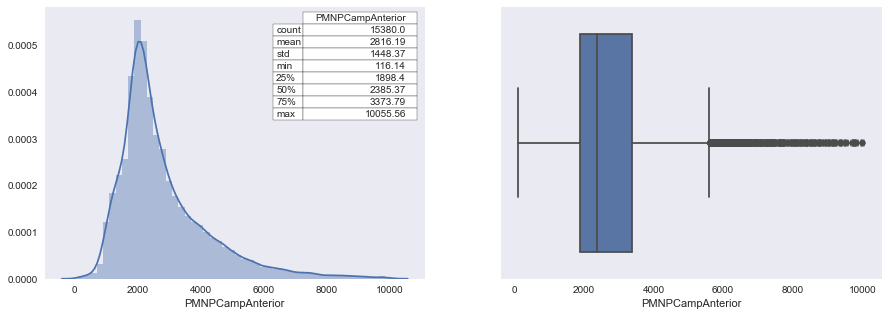

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table 
%matplotlib inline

def VarDescr(variable):
    sns.set()
    sns.set_style("dark")
    fig, ax = plt.subplots(figsize=(15,5), ncols=2)

    table(ax[0], np.round(variable.describe(), 2),loc='upper right', colWidths=[0.3, 0.3])
    sns.distplot(variable, ax = ax[0])
    sns.boxplot(x=variable, ax = ax[1])    
    
    return None 

#VarDescr(df2['PMNPCampAnterior'])

df2so = df2[np.abs(df2.PMNPCampAnterior-df2.PMNPCampAnterior.mean())<=(3*df2.PMNPCampAnterior.std())]

VarDescr(df2so['PMNPCampAnterior'])



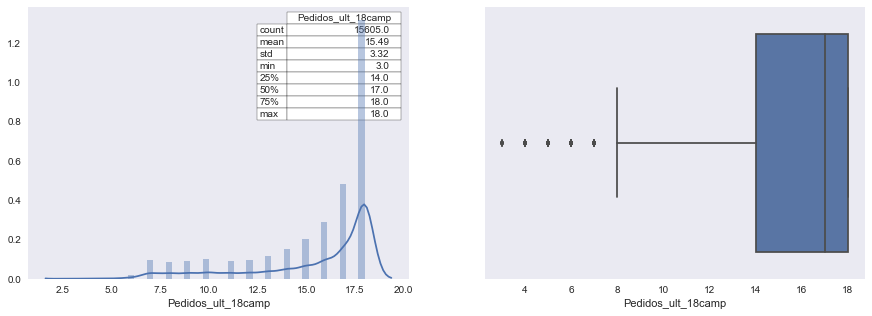

In [16]:
VarDescr(df2['Pedidos_ult_18camp'])

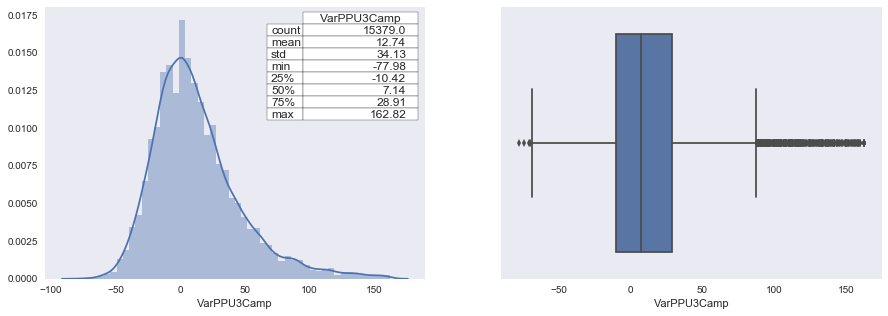

In [17]:


VarDescr(df2[np.abs(df2.VarPPU3Camp-df2.VarPPU3Camp.mean())<=(3*df2.VarPPU3Camp.std())].VarPPU3Camp)

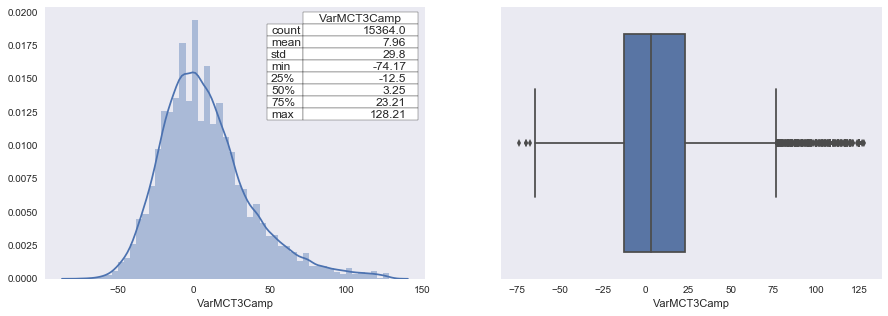

In [18]:
VarDescr(df2[np.abs(df2.VarMCT3Camp-df2.VarMCT3Camp.mean())<=(3*df2.VarMCT3Camp.std())].VarMCT3Camp)

### Correlación de variables

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
def corr_1(df):
    sns.set(style="white") 
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 8))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

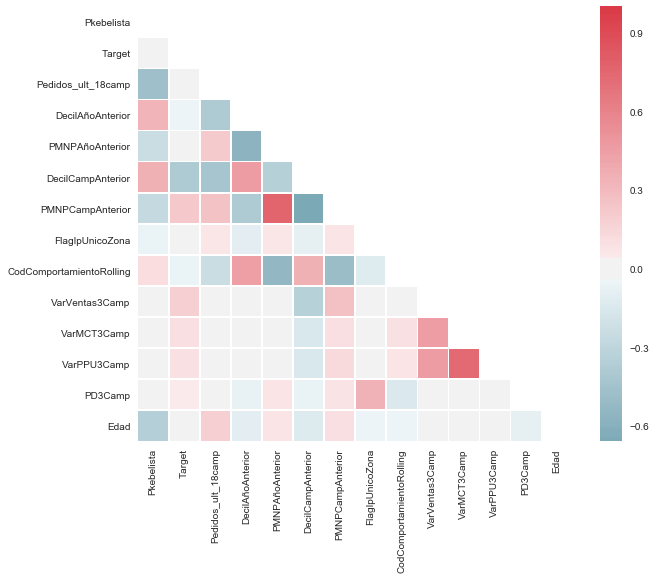

In [20]:
%matplotlib inline

corr_1(df2)

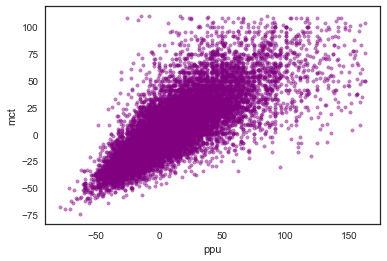

In [21]:
import matplotlib.pyplot as plt
import matplotlib

#columnas sin outlier
fppu = df2[np.abs(df2.VarPPU3Camp-df2.VarPPU3Camp.mean())<=(3*df2.VarPPU3Camp.std())]
fmct = fppu[np.abs(fppu.VarMCT3Camp-fppu.VarMCT3Camp.mean())<=(3*fppu.VarMCT3Camp.std())]

plt.scatter(fmct.VarPPU3Camp, fmct.VarMCT3Camp, c="purple", alpha=0.5, marker='.')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

plt.xlabel("ppu")
plt.ylabel("mct")
plt.show()

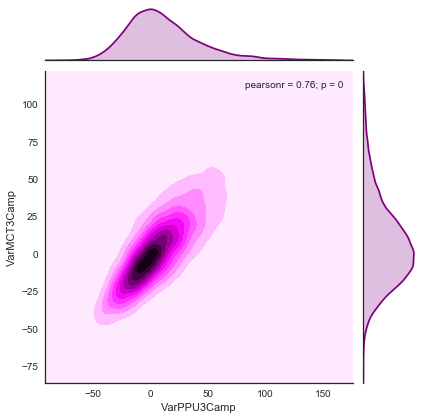

In [22]:
sns.jointplot(x=fmct.VarPPU3Camp, y=fppu.VarMCT3Camp, data=fmct, kind="kde", color="purple")

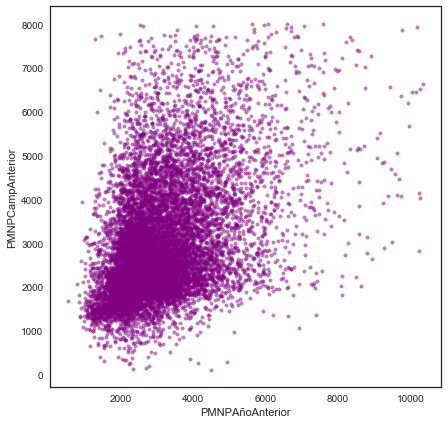

In [23]:
import matplotlib.pyplot as plt
import matplotlib
df22 =  df2.dropna(axis=0, how='all', subset=['DecilAñoAnterior', 'PMNPAñoAnterior'])
faño = df22[np.abs(df22.PMNPAñoAnterior-df22.PMNPAñoAnterior.mean())<=(3*df22.PMNPAñoAnterior.std())]
fcamp = faño[np.abs(faño.PMNPCampAnterior-faño.PMNPCampAnterior.mean())<=(3*faño.PMNPCampAnterior.std())]


plt.scatter(fcamp.PMNPAñoAnterior, fcamp.PMNPCampAnterior, c="purple", alpha=0.5, marker='.')
plt.xlabel("PMNPAñoAnterior")
plt.ylabel("PMNPCampAnterior")
#plt.legend(loc=2)
plt.show()

## Modelo

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

from xgboost import XGBClassifier




In [25]:
from sklearn.preprocessing import Imputer
df21 = df2.fillna(0)
df21 = df21.drop(['Pkebelista'], axis=1)

df21[df21.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
X_train, X_test, y_train, y_test = train_test_split(
df21.loc[:, df21.columns != 'Target'],
 df21[u'Target'].values, 
 test_size=0.15, 
 random_state=42)

xg = XGBClassifier()
xg.fit(X_train, y_train)

print(xg)


y_pred = xg.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_test, y_pred))


scores = cross_val_score(xg, df21.loc[:, df21.columns != 'Target'],df21[u'Target'].values,  cv=6)
#scoring = 'f1'
#scoring log
print('Cross-validated scores: ', scores, 'prom', np.mean(scores))

#feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, 
#columns=['importance']).sort_values('importance', ascending=False)

#print(feature_importances)





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
             precision    recall  f1-score   support

          0       0.74      0.77      0.75      1342
          1       0.67      0.63      0.65       999

avg / total       0.71      0.71      0.71      2341

Cross-validated scores:  [ 0.7101115   0.7289504   0.70703576  0.7101115   0.70588235  0.71653846] prom 0.713104994134


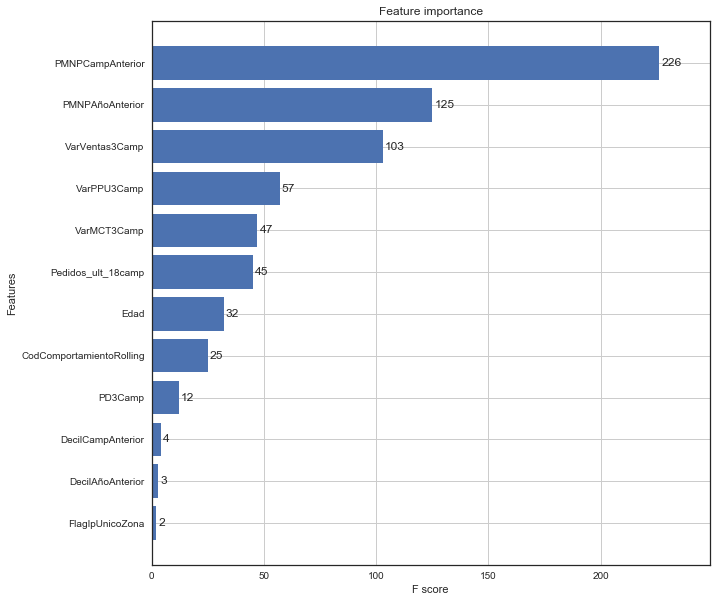

In [26]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xg, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [28]:
# 1. Borrando filas con NA en datos del año anterior: trabajamos solo con registros de los cuales se tiene data desde el año pasado.
#df21 = df2.dropna(axis=0, how='all', subset=['DecilAñoAnterior', 'PMNPAñoAnterior'])
# reemplazando NA con un valor para que entren al modelo las filas de las nuevas y no se queden sin estimación.
df21 = df2.fillna(0)
df21 = df21.drop(['Pkebelista'], axis=1)

print(df21.shape)
print(df21.isnull().values.any())


X_train, X_test, y_train, y_test = train_test_split(
df21.loc[:, df21.columns != 'Target'],
 df21[u'Target'].values, 
 test_size=0.15, 
 random_state=42)


niveles_arbol = 5
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = niveles_arbol)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))


scores = cross_val_score(clf, df21.loc[:, df21.columns != 'Target'],df21[u'Target'].values,  cv=6)
print('Cross-validated scores: ', scores, 'prom', np.mean(scores))

feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, 
columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

(15605, 13)
False
             precision    recall  f1-score   support

          0       0.73      0.75      0.74      1342
          1       0.65      0.62      0.63       999

avg / total       0.69      0.69      0.69      2341

Cross-validated scores:  [ 0.69742407  0.71049596  0.69665513  0.70049981  0.70818916  0.7       ] prom 0.702210688197
                          importance
PMNPCampAnterior            0.770910
PMNPAñoAnterior             0.172801
Pedidos_ult_18camp          0.018930
VarVentas3Camp              0.016667
CodComportamientoRolling    0.010813
VarPPU3Camp                 0.006948
Edad                        0.002931
DecilAñoAnterior            0.000000
DecilCampAnterior           0.000000
FlagIpUnicoZona             0.000000
VarMCT3Camp                 0.000000
PD3Camp                     0.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred) 

In [ ]:
from sklearn.metrics import confusion_matrix

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


In [ ]:
labels = ['Sí Cae', 'Sube o Mantiene']
print_cm(cnf_matrix, labels)

In [ ]:

!git add . 

In [ ]:
!git commit -m "added outlier hadling"

In [ ]:
!git push origin develop

In [ ]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, 
columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

# Next steps

- Hacer que el query de la tabla se actualice automaticamente desde este script

- Traerlo a Dolar

- Probar con otros países y campañas

- Probar otros algoritmos (XGBoost, LightGBM)

- Validar variables con visión de negocio, incorporar nuevas



- BONUS: Integrar con arquitectura AWS

In [ ]:
normalizar variables (normalizer) antes de xgboost
ver distribucion de los datos para encontrar outlier (o graficos de cajas)
perfilar consultoras para ponerle perfiles a las que no estaban hace un año

t-sne
https://seaborn.pydata.org/generated/seaborn.distplot.html